##Setup

In [1]:
%matplotlib inline

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs

In [5]:
from numpy import save

In [6]:
from skimage.io import imsave, imread

In [7]:
from regional import many
from numpy import random

In [10]:
def normalize(oim):
    # normalizes 3D image across first axis
    assert oim.ndim == 3
    
    means = oim.mean(axis=(1, 2), dtype='float32')
    return array([oim[i]/means[i]/4 for i in range(oim.shape[0])]).clip(0, 1)

##Set directory and session information

In [12]:
directory = '/volumes/freeman/Nick/lfov.calibration'

In [13]:
key = '2016-04-16-L23'
name = 'anm-0330549'

In [14]:
path = join(directory, 'reprocessed', name, key)
print exists(path)

True


##Create savepath

In [15]:
savepath = join(path, 'sources')
if not exists(savepath):
    makedirs(savepath)

##Load data

In [17]:
data = imread(join(path, 'summary', 'localcorr.tif'), plugin='tifffile')
#data = data.astype('float32')/255

In [16]:
#norm = normalize(data)

In [32]:
img = data[:200,:200]

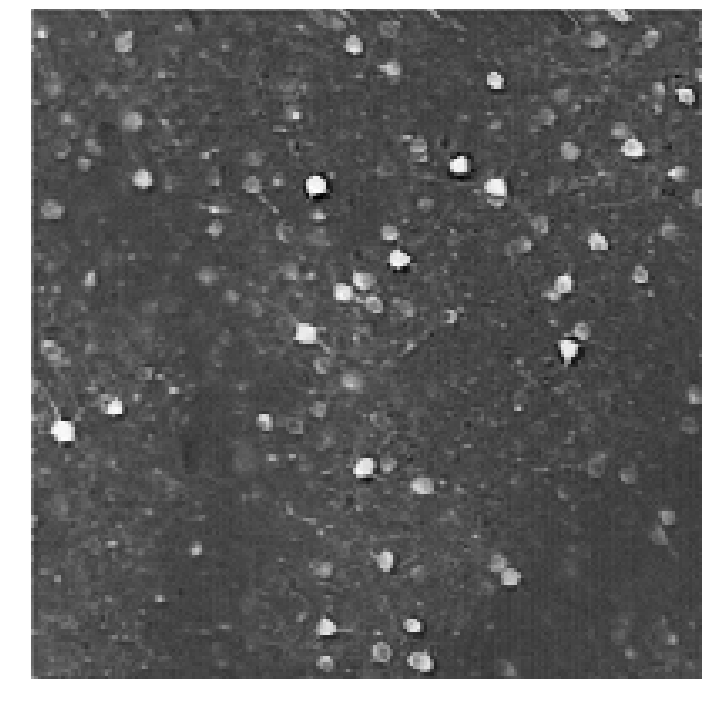

In [33]:
image(img, size=12)

## Blob finding

In [30]:
from skimage.filters import gaussian_filter
from skimage.feature import peak_local_max

In [22]:
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal

In [46]:
def inside(im, center, window):
    inside = [(center[i]-window[i] >= 0) & (center[i]+window[i] <= im.shape[i]) for i in range(0,2)]
    inside = np.all(inside)
    return inside

In [47]:
def volume(im, center, window):
    if np.all(inside(im, center, window)):
        volume = im[(center[0]-window[0]):(center[0]+window[0]), (center[1]-window[1]):(center[1]+window[1])]
        volume = volume.astype('float64')
        baseline = volume[[0,-1],[0,-1]].mean()
        volume = volume - baseline
        volume = volume/volume.max()
        return volume

In [82]:
imgT = thunder.images.fromarray(img)

In [158]:
smoothed = imgT.gaussian_filter(1)

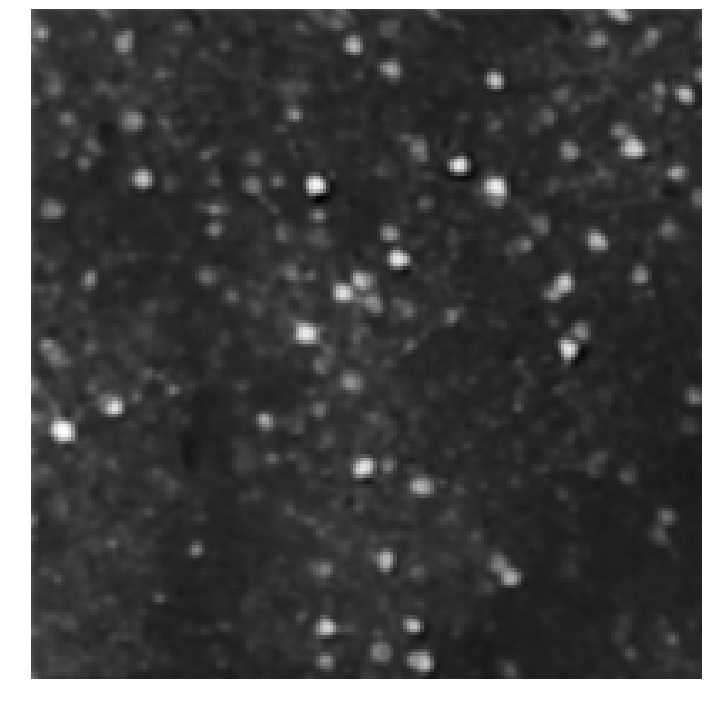

In [159]:
image(smoothed, size=12)

In [123]:
peak_local_max?

In [176]:
threshold_abs = np.percentile(smoothed.toarray().flatten(),70)
print threshold_abs
threshold_rel = np.percentile(smoothed.toarray().flatten(),80) - threshold_abs
print threshold_rel

0.32793405056
0.0146258711815


In [177]:
def findBeads(img):
    centers = peak_local_max(img, min_distance=1, threshold_rel=threshold_rel, threshold_abs=threshold_abs, exclude_border=False)
    return centers

In [178]:
centers = findBeads(smoothed.toarray())

(200, 0)

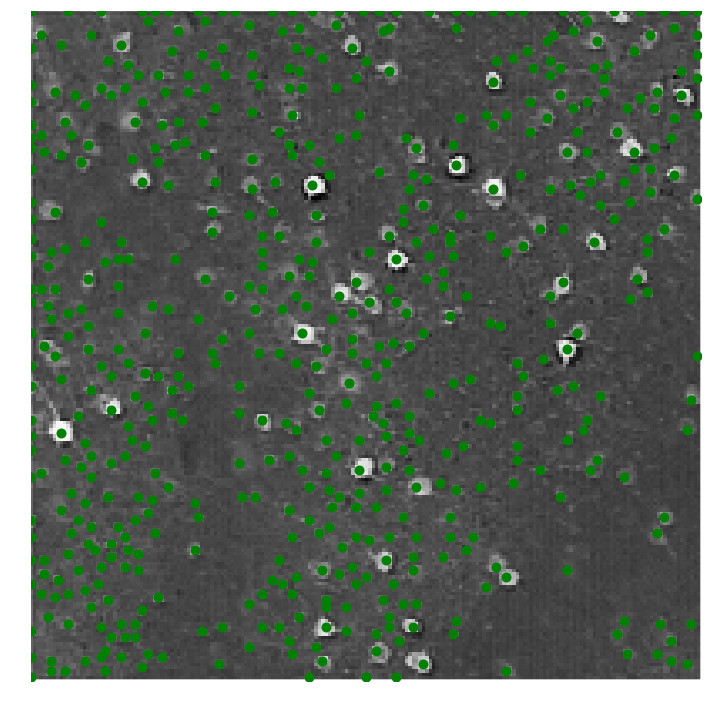

In [181]:
image(img, size=12)
plt.plot(centers[:,1], centers[:,0], 'g.', ms=20);
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])

In [48]:
def getCenters(im, options):
    window = [options['windowUm'][0]*options['pxPerUmAx'], options['windowUm'][1]*options['pxPerUmLat']]
    window = [round(x) for x in window]
    centers, smoothed = findBeads(im, window)
    print len(centers)
    beads = [volume(im, x, window) for x in centers]
    maxima = [im[x[0], x[1]] for x in centers]
    return beads, maxima, centers, smoothed

In [49]:
FOVumLat = 590.0
FOVpxLat = 512.0 # 512
pxPerUmLat = FOVpxLat/FOVumLat
pxPerUmAx = .05 # 2.0
wavelength = 970.0
NA = 0.6
windowUm = [2, 2]
options = {'FOVumLat':FOVumLat, 'FOVpxLat':FOVpxLat, 'pxPerUmLat':FOVpxLat/FOVumLat, 'pxPerUmAx':pxPerUmAx, 'wavelength':970.0, 'NA':0.6, 'windowUm':windowUm}

In [50]:
import numpy as np

In [51]:
beads, maxima, centers, smoothed = getCenters(patch, options)

942


/Users/sofroniewn/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
img = data

##Select plane (if necessary)

In [56]:
plane = 0
img = norm[plane]

##Load sources

In [205]:
with open(join(path, 'sources', 'sources-%04d.tif' % plane)) as fid:
    sources = many([x['coordinates'] for x in json.load(fid)])

IOError: [Errno 2] No such file or directory: '/volumes/freeman/Nick/lfov.calibration/reprocessed/anm-0326049/2016-04-01/sources/sources-0000.tif'

##Show image

In [19]:
viz = lgn.imagepoly(img)
viz

ConnectionError: HTTPConnectionPool(host='kafka1.int.janelia.org', port=3000): Max retries exceeded with url: /sessions/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x4ca0190>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
X = viz.points(z=plane)

In [ ]:
X

In [58]:
sources = many(viz.points(z=plane))

##Show sources

In [65]:
from numpy import maximum, tile

In [77]:
base.shape

(512, 512, 4, 3)

In [74]:
sources[0]

region
center: [254.6043956043956, 282.5824175824176, 0.0]
bbox: [[250, 259], [277, 288], [0, 0]]

In [78]:
base = tile(norm,(3,1,1,1)).transpose(1,2,3,0).transpose(1,2,0,3)
masks = sources.mask((512,512,4), background='black', fill='blue', stroke='orange')
blend = maximum(base, masks)

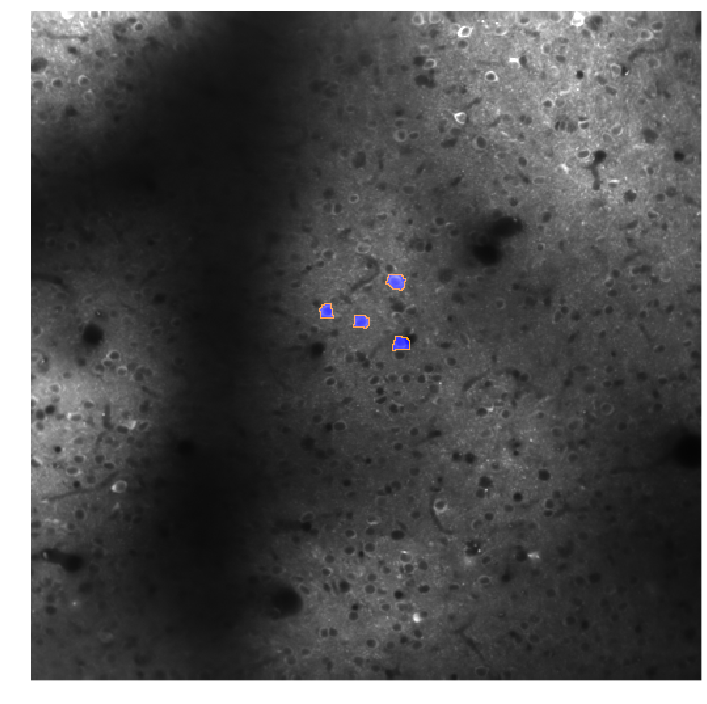

In [81]:
fig = plt.figure(figsize=[12,12])
ax = plt.axes()
im = image(blend[:,:,0], ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);
#for s in range(sources.count):
#    plt.annotate(s=str(s), xy=[sources.center[s][1],sources.center[s][0]], color='w', size = 20);

In [82]:
imsave(join(path, 'sources', 'sources.tif'), (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')
#imsave(join(path, 'sources', 'sources.tif'), (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

IOError: [Errno 57] Socket is not connected

In [203]:
imsave(join(path, 'sources', 'sources-%04d.tif' % plane), (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

IOError: [Errno 2] No such file or directory: '/volumes/freeman/Nick/lfov.calibration/reprocessed/anm-0326049/2016-04-01/sources/sources-0000.tif'

In [207]:
###multi dim nature of this ...

In [ ]:
foo = sources.masks((512,512,4), color='blue', base=X)
image(foo[:,:,1,:])

In [227]:
from numpy import concatenate

In [231]:
x = many([[concatenate((x, [plane])) for x in roi.coordinates] for roi in sources])

In [235]:
if norm.ndim == 2:
    base = tile(norm,(3,1,1)).transpose(1,2,0)
    masks = sources.mask(norm.shape, background='black', fill='blue', stroke='orange')
    blend = maximum(base, masks)
else:
    base = tile(norm,(3,1,1,1)).transpose(1,2,3,0)
    masks = [sources.mask(norm.shape, background='black', fill='blue', stroke='orange')



ValueError: operands could not be broadcast together with shapes (4,) (2,) 

In [ ]:
def mask(sources, shape, **kwargs):
    if len(shape) == 3:
        
    else:
        return sources.mask(shape, **kwargs)

In [1]:
import regional

In [2]:
regional.__version__

'1.0.1'

In [19]:
a = [1, 18, 35]
b = [2, 20, 40]

In [5]:
import numpy as np

In [20]:
x = np.stack((a, b), axis = 1)

In [21]:
x

array([[ 1,  2],
       [18, 20],
       [35, 40]])

In [23]:
x[:,0]

array([ 1, 18, 35])

##Save sources

##ImageJ

In [21]:
from sima.misc.imagej import read_imagej_roi_zip

In [25]:
X = read_imagej_roi_zip('/Users/sofroniewn/github/regional/RoiSet.zip')

In [33]:
X[0]

{u'label': u'0056-0064-0067', u'polygons': array([[ 39.,  79.,  55.],
        [ 39.,  80.,  55.],
        [ 38.,  80.,  55.],
        [ 38.,  81.,  55.],
        [ 38.,  82.,  55.],
        [ 38.,  83.,  55.],
        [ 38.,  84.,  55.],
        [ 38.,  85.,  55.],
        [ 38.,  86.,  55.],
        [ 38.,  87.,  55.],
        [ 38.,  88.,  55.],
        [ 38.,  89.,  55.],
        [ 39.,  89.,  55.],
        [ 40.,  89.,  55.],
        [ 41.,  90.,  55.],
        [ 42.,  90.,  55.],
        [ 44.,  90.,  55.],
        [ 45.,  90.,  55.],
        [ 46.,  90.,  55.],
        [ 48.,  90.,  55.],
        [ 49.,  89.,  55.],
        [ 50.,  88.,  55.],
        [ 50.,  87.,  55.],
        [ 50.,  86.,  55.],
        [ 49.,  85.,  55.],
        [ 48.,  84.,  55.],
        [ 48.,  83.,  55.],
        [ 47.,  82.,  55.],
        [ 46.,  81.,  55.],
        [ 46.,  80.,  55.],
        [ 45.,  80.,  55.],
        [ 44.,  80.,  55.],
        [ 43.,  80.,  55.],
        [ 42.,  80.,  55.],
      

In [38]:
Y[0]

array([[78, 38],
       [79, 38],
       [79, 37],
       [80, 37],
       [81, 37],
       [82, 37],
       [83, 37],
       [84, 37],
       [85, 37],
       [86, 37],
       [87, 37],
       [88, 37],
       [88, 38],
       [88, 39],
       [89, 40],
       [89, 41],
       [89, 43],
       [89, 44],
       [89, 45],
       [89, 47],
       [88, 48],
       [87, 49],
       [86, 49],
       [85, 49],
       [84, 48],
       [83, 47],
       [82, 47],
       [81, 46],
       [80, 45],
       [79, 45],
       [79, 44],
       [79, 43],
       [79, 42],
       [79, 41],
       [79, 40],
       [79, 39]], dtype=int16)

In [35]:
Y = read_roi_zip('/Users/sofroniewn/github/regional/RoiSet.zip')

In [34]:
# Copyright: Luis Pedro Coelho <luis@luispedro.org>, 2012
# License: MIT
import numpy as np

def read_roi(fileobj):
    '''
    points = read_roi(fileobj)
    Read ImageJ's ROI format
    '''
# This is based on:
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiEncoder.java.html


    SPLINE_FIT = 1
    DOUBLE_HEADED = 2
    OUTLINE = 4
    OVERLAY_LABELS = 8
    OVERLAY_NAMES = 16
    OVERLAY_BACKGROUNDS = 32
    OVERLAY_BOLD = 64
    SUB_PIXEL_RESOLUTION = 128
    DRAW_OFFSET = 256


    pos = [4]
    def get8():
        pos[0] += 1
        s = fileobj.read(1)
        if not s:
            raise IOError('readroi: Unexpected EOF')
        return ord(s)

    def get16():
        b0 = get8()
        b1 = get8()
        return (b0 << 8) | b1

    def get32():
        s0 = get16()
        s1 = get16()
        return (s0 << 16) | s1

    def getfloat():
        v = np.int32(get32())
        return v.view(np.float32)

    magic = fileobj.read(4)
    if magic != 'Iout':
        raise IOError('Magic number not found')
    version = get16()

    # It seems that the roi type field occupies 2 Bytes, but only one is used
    roi_type = get8()
    # Discard second Byte:
    get8()

    if not (0 <= roi_type < 11):
        raise ValueError('roireader: ROI type %s not supported' % roi_type)

    if roi_type != 7:
        raise ValueError('roireader: ROI type %s not supported (!= 7)' % roi_type)

    top = get16()
    left = get16()
    bottom = get16()
    right = get16()
    n_coordinates = get16()

    x1 = getfloat() 
    y1 = getfloat() 
    x2 = getfloat() 
    y2 = getfloat()
    stroke_width = get16()
    shape_roi_size = get32()
    stroke_color = get32()
    fill_color = get32()
    subtype = get16()
    if subtype != 0:
        raise ValueError('roireader: ROI subtype %s not supported (!= 0)' % subtype)
    options = get16()
    arrow_style = get8()
    arrow_head_size = get8()
    rect_arc_size = get16()
    position = get32()
    header2offset = get32()

    if options & SUB_PIXEL_RESOLUTION:
        getc = getfloat
        points = np.empty((n_coordinates, 2), dtype=np.float32)
    else:
        getc = get16
        points = np.empty((n_coordinates, 2), dtype=np.int16)
    points[:,1] = [getc() for i in xrange(n_coordinates)]
    points[:,0] = [getc() for i in xrange(n_coordinates)]
    points[:,1] += left
    points[:,0] += top
    points -= 1
    return points

def read_roi_zip(fname):
    import zipfile
    with zipfile.ZipFile(fname) as zf:
        return [read_roi(zf.open(n))
                    for n in zf.namelist()]